<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/roberta_and_tpus_ptacek_run2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with RoBERTa

The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu et al. It is based on Google’s BERT model released in 2018: it modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

See:
- RoBERTa's paper: https://arxiv.org/pdf/1907.11692.pdf
- BERT's paper: https://arxiv.org/pdf/1810.04805.pdf

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 69.7 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 636 kB 84.9 MB/s 
     |████████████████████████████████| 895 kB 78.7 MB/s 


In [36]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.127.107.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.127.107.194:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.127.107.194:8470
Number of replicas: 8


In [ ]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 128
ARTIFACTS_PATH = './drive/MyDrive/artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 5

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
exit()

## Prepare dataset

Note that I have already cleaned the dataset, so the training should be better:
- Remove punctuation symbols and double white spaces.
- Lemmatization.
- Remove stop words (see `spacy.lang.en.stop_words.STOP_WORDS`).
- TD-IDF

The reason of this preprocess is that I have used this dataset with other models, such as LSTM. However, I believe (I didn't test it) that RoBERTa could deal with it.

In [ ]:
df = pd.read_csv('/drive/MyDrive/datasets/cleaned_ptacek_wtweets_wnotebook.csv')
df.head()

,Unnamed: 0,index,Tweet_id,Tweet,Label
0,0,0,411348816583856129,peyton obviously cannot finish games he just t...,1
1,1,1,408111537011036160,well i would love to be sleeping right now but...,1
2,2,2,403282506230665217,my biggest executive decision today choosing b...,1
3,3,3,409720467662983168,the first quality opponent they played in 2 y...,1
4,4,4,403005765608554496,but do not you dare call it hate crimes libe...,1


In [ ]:
df.columns = df.columns.str.lstrip()

In [ ]:
X_data = df[['Tweet']].to_numpy()
y_data = df[['Label']].to_numpy()

In [ ]:
print(X_data[90:93])

[['i am hearing multiple reports that redsox are looking at youkilis as their utility infielder  feel he can play quality ss  ']
 ['got to go to the doctors at 845am on friday looking forward to it ']
 ['“ my nights gonna be so fun 🙈  babysitting like 20 kids 😍    😫  🔫 ”']]


In [ ]:
!pip install emoji

     |████████████████████████████████| 168 kB 5.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=fc5ec1a59f7662ea5e7d2d68b011f56b2bf6735d1077c3f1a755525c94458e2c
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji


In [ ]:
import emoji
def extract_emojis(s):
    return ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in s)

In [ ]:
df['Tweet'] = df['Tweet'].apply(extract_emojis)

In [ ]:
X_data = X_data.reshape(-1)
y_data = y_data.reshape(-1)

In [ ]:
print(X_data[:10])

['peyton obviously cannot finish games he just throws interceptions when the game is on the line just like romo firepeytonmanning '
 'well i would love to be sleeping right now but nooooooo lets just stay awake all might that is what i wanted to do  cantsleep blah'
 'my biggest executive decision today choosing between georgetown cupcakes andamp sprinkles i still have not decided '
 ' the first quality opponent they played in 2 years and they lose shocked '
 ' but do not you dare call it hate crimes  liberallogic'
 'its always a good day when you think you failed a test '
 'i am going to have such a wonderful weekend yay so stoked just kidding  tothemax'
 'great i have a night class next semester oh the joy '
 '   loll hahahahahahaha funny as he will funny '
 'this week just keeps getting better and better ']


# Dataset analysis

As you can see in the following plot, the samples **are not balanced**. This could cause problems during the training but, since they are not highly unbalanced, I have left it as it is.

In other cases, such as fraud detecting where the positive classes are very few compared to the negative ones, we must apply techniques to balance it. For example, we could undersample the biggest category.

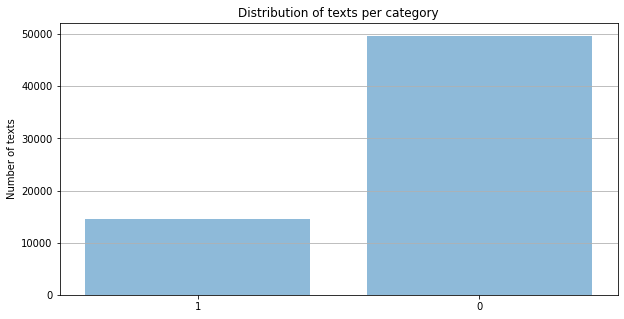

Counter({0: 49654, 1: 14580})


In [ ]:
categories = df[['Label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
def calculate_stats(df, split_char=' '):
    categories = df['Label'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['Tweet']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['Label']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['Label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In these histograms and stats, we can see that almost all texts contain $500$ or less words. Also, we can see that the average length is very different depending on the category.

Please, note that the tokenization process may split words into several parts, so lengths could increase (or decrease too). This is only an orientative result.

In [ ]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
1,"[21, 26, 17, 15, 11, 13, 15, 12, 9, 9, 17, 25,...",16.104047,5.183757
0,"[16, 9, 10, 21, 16, 12, 17, 19, 15, 13, 8, 10,...",14.484231,5.326436


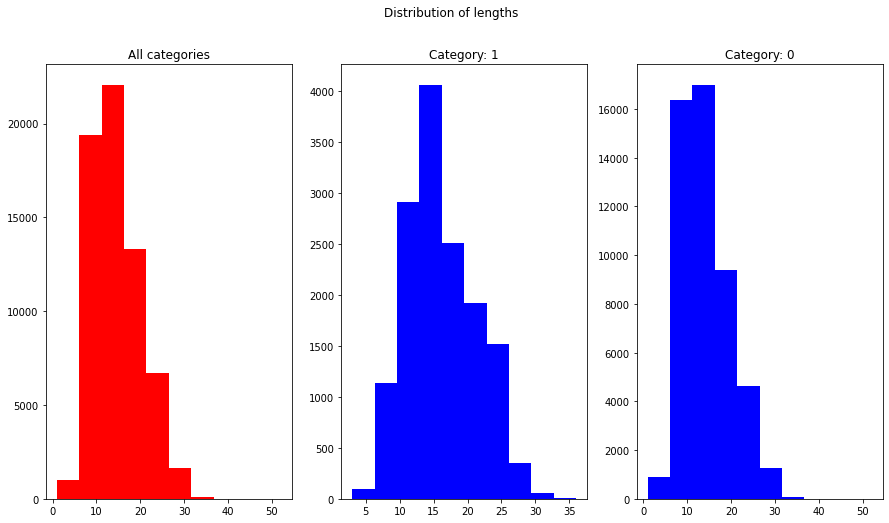

In [ ]:
display_lengths_histograms(df_stats)

In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['Label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 64234
Number of categories: 2
Done!


# Tokenize & encode

I am going to import the RoBERTa model from HuggingFace. Note that I must import not only the model but also the tokenizer (since I must use the same vocabulary as the model was trained with).

We should take into account that RoBERTa's input accepts up-to 512 tokens, thus **we must truncate the tokenized texts**. In my case, I truncate to 256 tokens, but you can put a higher value in the variable `MAX_LEN`.

See https://huggingface.co/roberta-base

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text= tokenizer.add_tokens(['😀', '😏', '☺️', '🎾', '🍧', '💔', '📯', '😿', '😶', '🍔', '🇬🇧', '📖', '😊', '🌏', '🎸', '😥', '🍝', '🎌', '✋', '😳', '💅', '👆', '🔮', '🍬', '👈', '😍', '😕', '🚬', '🔥', '☃', '🔞', '👔', '🏊', '💝', '🐒', '🎈', '🌴', '🏃', '🍩', '👎', '🍤', '💩', '©', '🚴', '🐣', '👻', '🚼', '💊', '🌱', '🙆', '🙅', '👅', '🐤', '❗', '✖', '💰', '⚡', '💂', '⬅️', '💚', '💌', '🍕', '🎁', '👊', '😱', '🌌', '📚', '💞', '🍭', '⛄', '👳', '🎤', '📀', '💨', '😁', '😨', '💖', '🚗', '😇', '💧', '🇫🇷', '😎', '🌃', '〰', '💽', '🏂', '🆒', '🍦', '😩', '🌻', '💀', '⏰', '🍲', '🚢', '😅', '🍅', '😣', '👱', '😈', '🎆', '🍳', '🎎', '🍗', '💙', '🙊', '☹', '🍸', '💐', '🌅', '🎮', '🐬', '😯', '👃', '🍷', '🍖', '😒', '🍊', '🌸', '🍻', '🐽', '😰', '🆘', '🐛', '🍃', '😠', '🍰', '🎿', '🙌', '😪', '☠', '☀️', '▶', '👀', '🍺', '😢', '👫', '🙈', '🚔', '🎊', '😑', '🎹', '◽', '☮', '✊', '👩', '🚨', '💕', '⭐', '❌', '👬', '😭', '🌲', '🌀', '🍹', '💆', '👌', '▪', '💎', '➡️', '😓', '☺', '🍓', '💋', '🐾', '🍛', '👠', '🌆', '™', '📓', '🙀', '🚀', '🙋', '💢', '🎼', '🍍', '✴', '😽', '😝', '👶', '😫', '😐', '❄', '💻', '👙', '✔️', '😵', '😬', '😮', '🍉', '👾', '🏄', '😚', '🎨', '💛', '😜', '🐥', '🔄', '🌠', '❄️', '👋', '😦', '🔆', '💯', '🌞', '😌', '💁', '🎉', '📺', '♦', '🕑', '🌎', '🎶', '👏', '😃', '🐇', '🍏', '🇩🇪', '☕', '😴', '🎵', '🌍', '🙉', '👂', '😷', '🐶', '🕥', '👯', '🌙', '🕐', '😙', '🎀', '💸', '😆', '🔫', '♏', '😉', '👭', '🐷', '💘', '👿', '♥', '☁️', '🎓', '😂', '⁉️', '😟', '💟', '💜', '😤', '🌊', '🌾', '🐴', '🍨', '🏡', '🐰', '😲', '💳', '🚶', '🍁', '😡', '🐳', '🔪', '🍠', '🌁', '😻', '🔯', '🔅', '🍀', '🎻', '🍵', '🐠', '👉', '☀', '👪', '✌', '👜', '💥', '😹', '👣', '🍈', '🇺🇸', '📨', '🇮🇹', '😗', '🌚', '💵', '🙍', '🎄', '🐉', '◾', '🌂', '💍', '⛪', '🎧', '❤️', '®', '❤', '👑', '💣', '🍋', '🎺', '📑', '🚺', '😘', '✌️', '🚫', '🌽', '💤', '🎥', '✏', '💪', '🏰', '😞', '✖️', '👹', '📣', '😺', '😄', '👰', '☔', '🎅', '😔', '☂', '💼', '🚓', '🍫', '👄', '💄', '👐', '💗', '🌵', '🐟', '💃', '🙏', '✨', '☝️', '☁', '🏈', '🍪', '⛅', '💉', '🐭', '⚽', '😛', '🍟', '💏', '😋', '📄', '🏥', '🐼', '♥️', '😧', '💦', '🎷', '🎂', '📱', '🚙', '👼', '🍆', '✈', '👸', '🎭', '🐸', '👍', '✈️', '😖', '🎋', '🐧'])
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 1, 1: 0}

In [ ]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [ ]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

DEBUG:filelock:Attempting to acquire lock 140015508870480 on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
DEBUG:filelock:Lock 140015508870480 acquired on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140015508870480 on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
DEBUG:filelock:Lock 140015508870480 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
DEBUG:filelock:Attempting to acquire lock 140015509015376 on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:filelock:Lock 140015509015376 acquired on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140015509015376 on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:filelock:Lock 140015509015376 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:filelock:Attempting to acquire lock 140015509709072 on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
DEBUG:filelock:Lock 140015509709072 acquired on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140015509709072 on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
DEBUG:filelock:Lock 140015509709072 released on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
DEBUG:filelock:Attempting to acquire lock 140015508579472 on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
DEBUG:filelock:Lock 140015508579472 acquired on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140015508579472 on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
DEBUG:filelock:Lock 140015508579472 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

## Create RoBERTa model

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        roberta_model.resize_token_embeddings(len(tokenizer))
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=3e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

DEBUG:filelock:Attempting to acquire lock 140003701488976 on /root/.cache/huggingface/transformers/22fef2e3c5012c1a8f8d7f024e30275dd2925b076abb5131dc3d1068345b6426.d409db346b0c1408865b9785d36744ccb988186626309ae8f995f86511811602.h5.lock
DEBUG:filelock:Lock 140003701488976 acquired on /root/.cache/huggingface/transformers/22fef2e3c5012c1a8f8d7f024e30275dd2925b076abb5131dc3d1068345b6426.d409db346b0c1408865b9785d36744ccb988186626309ae8f995f86511811602.h5.lock


Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140003701488976 on /root/.cache/huggingface/transformers/22fef2e3c5012c1a8f8d7f024e30275dd2925b076abb5131dc3d1068345b6426.d409db346b0c1408865b9785d36744ccb988186626309ae8f995f86511811602.h5.lock
DEBUG:filelock:Lock 140003701488976 released on /root/.cache/huggingface/transformers/22fef2e3c5012c1a8f8d7f024e30275dd2925b076abb5131dc3d1068345b6426.d409db346b0c1408865b9785d36744ccb988186626309ae8f995f86511811602.h5.lock
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124926720   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

## Train model

This is basic training of RoBERTa but, if your dataset is larger, you may use K-Folds in this section. In this notebook, I use K-Folds (use it as inspiration): https://www.kaggle.com/dimasmunoz/clean-english-data-roberta ;)

In [ ]:
with strategy.scope():
    print('Starting training.....')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Starting training.....
Epoch 1/5


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int32>]


703/703 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.8996

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int32>]


703/703 [==============================] - 222s 207ms/step - loss: 0.2352 - accuracy: 0.8996 - val_loss: 0.1743 - val_accuracy: 0.9278
Epoch 2/5
703/703 [==============================] - 78s 111ms/step - loss: 0.1489 - accuracy: 0.9403 - val_loss: 0.1985 - val_accuracy: 0.9137
Epoch 3/5
703/703 [==============================] - 78s 110ms/step - loss: 0.0990 - accuracy: 0.9611 - val_loss: 0.1956 - val_accuracy: 0.9337
Epoch 4/5
703/703 [==============================] - 78s 110ms/step - loss: 0.0642 - accuracy: 0.9764 - val_loss: 0.2265 - val_accuracy: 0.9348
Epoch 5/5
703/703 [==============================] - 78s 111ms/step - loss: 0.0432 - accuracy: 0.9841 - val_loss: 0.2738 - val_accuracy: 0.9335


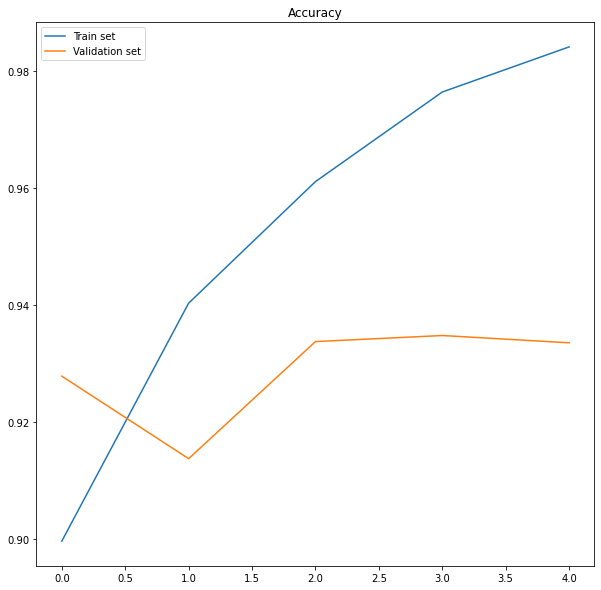

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

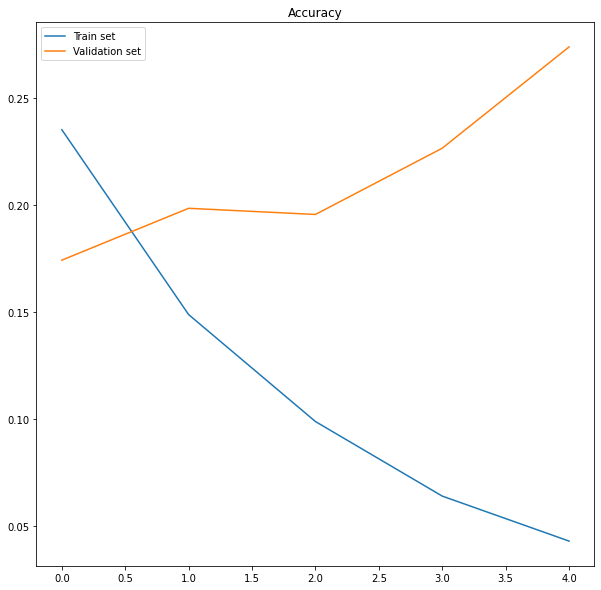

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['loss']))
plt.plot(xaxis, history.history['loss'], label='Train set')
plt.plot(xaxis, history.history['val_loss'], label='Validation set')
plt.legend()

## Evaluation

In a confusion matrix, we can see how many categories are classified c

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 93.35%


In [ ]:
class_names=['1', '0']

In [ ]:
y_pred= model.predict(X_test)
y_pred = [np.argmax(i) for i in model.predict(X_test)]
print(classification_report(y_test, y_pred, target_names=class_names))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 128) dtype=int32>]


              precision    recall  f1-score   support

           1       0.84      0.88      0.86      4374
           0       0.96      0.95      0.96     14897

    accuracy                           0.93     19271
   macro avg       0.90      0.91      0.91     19271
weighted avg       0.93      0.93      0.93     19271



In [38]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Lablel')
  plt.xlabel('Predicted label');

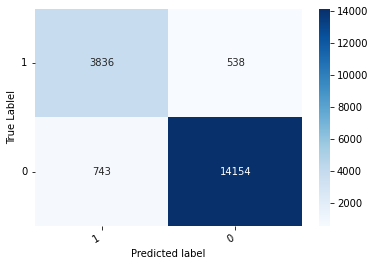

In [39]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

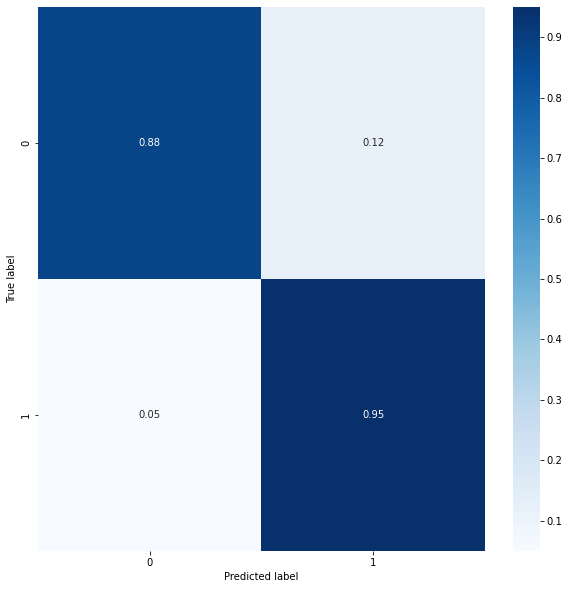

In [ ]:
plot_confusion_matrix(X_test, y_test, model)